# Wilcoxonの符号順位検定の頑健性チェック

* 黒木玄
* 作成: 2025-12-06
* 文脈: https://x.com/genkuroki/status/1996556375800025396
* Colab: https://colab.research.google.com/github/genkuroki/public/blob/main/0055/Wilcoxon's%20Signed%20rank%20test.ipynb

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

haskey(ENV, "COLAB_GPU") && (ENV["JULIA_PKG_PRECOMPILE_AUTO"] = "0")
using Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    sort!([info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep])]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if isnothing(Base.find_package(pkg))
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end
9
"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
using Random

_nthreads() = Threads.nthreads(:interactive) + Threads.nthreads(:default)

using Random
using Statistics

@autoadd begin
using Distributions
using HypothesisTests
using HCubature
using QuadGK
using Roots
using StatsPlots
#using Plots
end

default(fmt=:png, legend=false, size=(400, 400), titlefontsize=10, tickfontsize=7)

Base.show(io::IO, d::InverseGamma) =
    print(io, "InverseGamma(α=", d.invd.α, ", θ=", d.θ, ")")
Base.show(io::IO, ::MIME"text/plain", d::InverseGamma) = Base.show(io, d)
@eval Distributions begin
function logpdf(d::InverseGamma, x::Real)
    x ≤ 0 && return -Inf
    (α, θ) = params(d)
    α * log(θ) - loggamma(α) - (α + 1) * log(x) - θ / x
end
end

distname(dist) = replace(string(dist), r"{[^\}]*}"=>"")

_ecdf(A, x) = count(≤(x), A) / length(A)

function median_x1_plus_x2_monte_carlo(dist::ContinuousUnivariateDistribution; niters=10^8, naves=1)
    s = 0.0
    X1_plus_X2 = zeros(niters)
    for j in 1:naves
        Threads.@threads for i in 1:niters
            X1_plus_X2[i] = rand(dist) + rand(dist)
        end
        s += median!(X1_plus_X2)
    end
    s / naves
end

function prob_x1_plus_x2_gt_zero_monte_carlo(dist; niters=10^8, naves=1)
    s = 0.0
    X1_plus_X2 = zeros(niters)
    for j in 1:naves
        Threads.@threads for i in 1:niters
            X1_plus_X2[i] = rand(dist) + rand(dist)
        end
        s += count(>(0), X1_plus_X2) / length(X1_plus_X2)
    end
    s / naves
end

@show dist = Gamma(0.03, 10000)
@time m1 = median_x1_plus_x2_monte_carlo(dist)
@time m2 = median_x1_plus_x2_monte_carlo(dist)
@time m3 = median_x1_plus_x2_monte_carlo(dist)
@show m1 m2 m3
m = m1
@time p1 = prob_x1_plus_x2_gt_zero_monte_carlo(dist - m/2)
@time p2 = prob_x1_plus_x2_gt_zero_monte_carlo(dist - m/2)
@time p3 = prob_x1_plus_x2_gt_zero_monte_carlo(dist - m/2)
@show p1 p2 p3

dist = Gamma(0.03, 10000) = Gamma{Float64}(α=0.03, θ=10000.0)
  3.562977 seconds (400.30 M allocations: 12.690 GiB, 18.98% gc time, 21.54% compilation time)
  3.767846 seconds (400.00 M allocations: 12.676 GiB, 24.30% gc time)
  3.648293 seconds (400.00 M allocations: 12.676 GiB, 23.87% gc time)
m1 = 0.05671676038404885
m2 = 0.056783757926265714
m3 = 0.05665945202211577
  3.687466 seconds (400.37 M allocations: 12.683 GiB, 26.51% gc time, 7.91% compilation time)
  3.558971 seconds (400.00 M allocations: 12.666 GiB, 26.50% gc time)
  3.770113 seconds (400.00 M allocations: 12.666 GiB, 30.38% gc time)
p1 = 0.49996656
p2 = 0.4999464
p3 = 0.49991862


0.49991862

In [3]:
function sim_signed_rank_test(dist::ContinuousUnivariateDistribution, n;
        niters = 10^5,
        distshift = median_x1_plus_x2_monte_carlo(dist) / 2
    )
    dist_null = dist - distshift
    nth = _nthreads()
    Xtmp = [zeros(n) for _ in 1:nth]
    pval = zeros(niters)
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        X = rand!(dist_null, Xtmp[tid])
        pval[i] = pvalue(SignedRankTest(X))
    end
    pval
end

function plot_sim_signed_rank_test(dist::ContinuousUnivariateDistribution, n;
        niters = 10^5,
        str_dist = distname(dist), 
        distshift = median_x1_plus_x2_monte_carlo(dist) / 2,
        dist_null = dist - distshift,
        μ = mean(dist_null),
        σ = std(dist_null),
        xmin = μ - 5σ,
        xmax = μ + 5σ,
        xs = range(xmin, xmax, 2000),
        ymax = min(10, maximum(pdf(dist_null, x) for x in xs)),
        amax = 0.1,
        r = x -> round(x; digits=4),
        rsd = x -> round(x; sigdigits=4),
    )
    str_dist_null = str_dist * (distshift + 1 ≈ 1 ? "" : (distshift > 0 ? " - " : " + ") * "$(rsd(abs(distshift)))")
    
    println("Xᵢ ~ ", str_dist_null) 
    println("P(X₁ + X₂ > 0) = ", r(prob_x1_plus_x2_gt_zero_monte_carlo(dist_null)))
    println("P(X₁ > 0) = ", r(ccdf(dist_null, 0)))
    println("median(X₁)) = ", r(median(dist_null)))
    println("mean(X₁)) = ", r(mean(dist_null)))
    
    pval = sim_signed_rank_test(dist, n; niters, distshift)
    P = plot(xs, x -> pdf(dist_null, x))
    plot!(ylim=(-0.05ymax, 1.03ymax))
    title!("$str_dist_null,  n=$n")
    Q = plot(α -> _ecdf(pval, α), 0.0, amax)
    plot!(identity; ls=:dot, c=:black, alpha=0.5, lw=0.8)
    xtick = ytick = amax > 0.14 ? (0:0.1:1) : (0:0.01:1)
    plot!(; xtick, ytick)
    plot!(xguide="α", yguide="probability of P-value ≤ α")
    plot!(P, Q; size=(400, 560), layout=@layout[a{0.3h}; b])
end

plot_sim_signed_rank_test (generic function with 1 method)

Xᵢ ~ Normal(μ=0.0, σ=1.0) + 0.0001222
P(X₁ + X₂ > 0) = 0.5001
P(X₁ > 0) = 0.5
median(X₁)) = 0.0001
mean(X₁)) = 0.0001


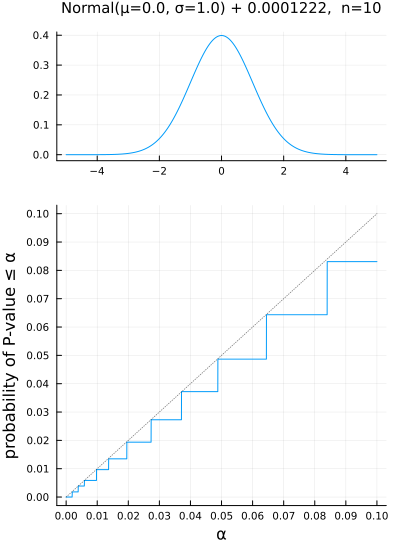

In [4]:
plot_sim_signed_rank_test(Normal(), 10)

Xᵢ ~ InverseGamma(α=2.01, θ=1.0) - 0.6925
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.4201
median(X₁)) = -0.1002
mean(X₁)) = 0.2976


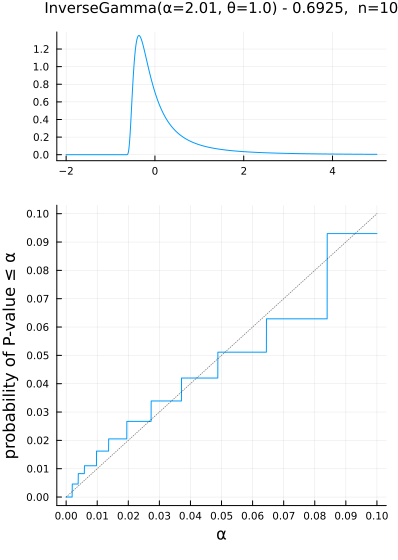

In [5]:
plot_sim_signed_rank_test(InverseGamma(2.01), 10; xmin=-2, xmax=5)

Xᵢ ~ LogNormal(μ=0.0, σ=1.0) - 1.222
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.4206
median(X₁)) = -0.2217
mean(X₁)) = 0.427


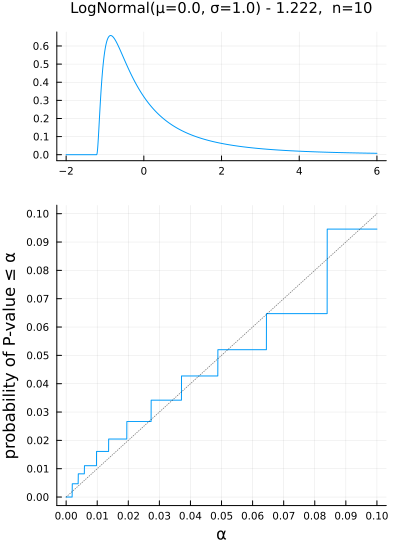

In [6]:
plot_sim_signed_rank_test(LogNormal(), 10; xmin=-2, xmax=6)

Xᵢ ~ Exponential(θ=1.0) - 0.8391
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.4321
median(X₁)) = -0.146
mean(X₁)) = 0.1609


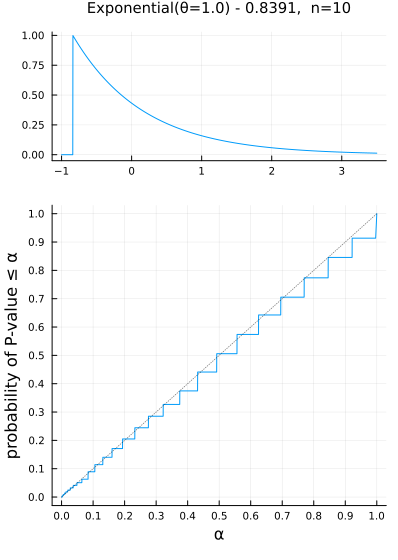

In [7]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5, amax=1)

Xᵢ ~ Exponential(θ=1.0) - 0.8392
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.432
median(X₁)) = -0.1461
mean(X₁)) = 0.1608


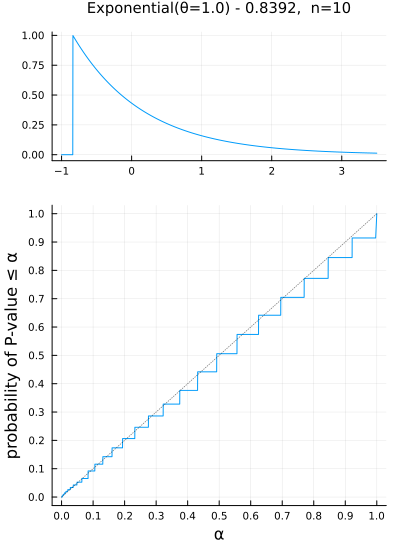

In [8]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5, amax=1)

Xᵢ ~ Exponential(θ=1.0) - 0.839
P(X₁ + X₂ > 0) = 0.5001
P(X₁ > 0) = 0.4321
median(X₁)) = -0.1459
mean(X₁)) = 0.161


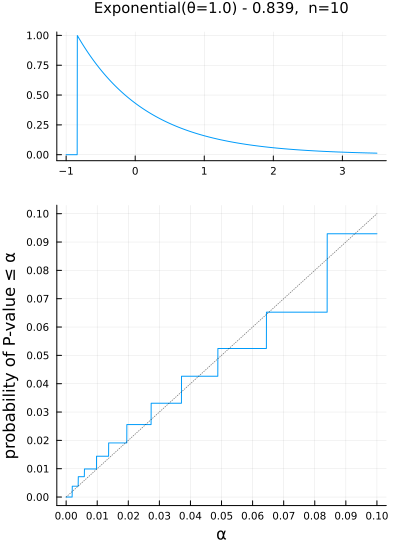

In [9]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5)

Xᵢ ~ Exponential(θ=1.0) - 0.8393
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.432
median(X₁)) = -0.1461
mean(X₁)) = 0.1607


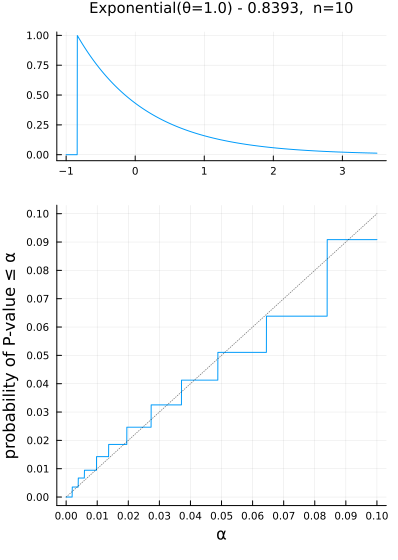

In [10]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5)

Xᵢ ~ Gamma(α=0.1, θ=10.0) - 0.1037
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.335
median(X₁)) = -0.0978
mean(X₁)) = 0.8963


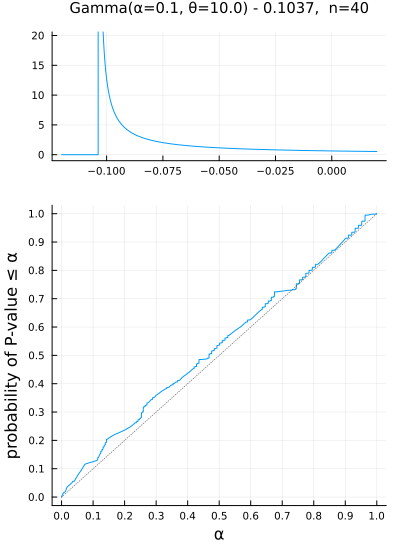

In [11]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20, amax=1)

Xᵢ ~ Gamma(α=0.1, θ=10.0) - 0.1038
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.3349
median(X₁)) = -0.0979
mean(X₁)) = 0.8962


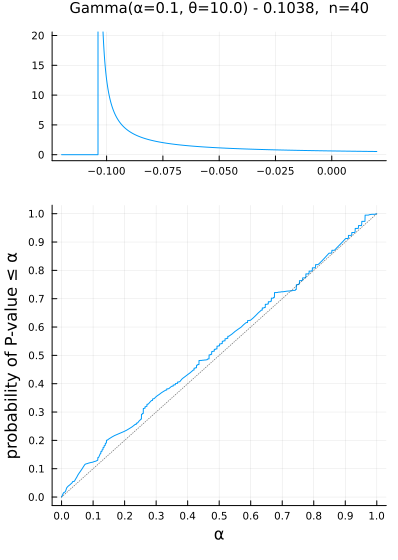

In [12]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20, amax=1)

Xᵢ ~ Gamma(α=0.1, θ=10.0) - 0.1038
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.335
median(X₁)) = -0.0978
mean(X₁)) = 0.8962


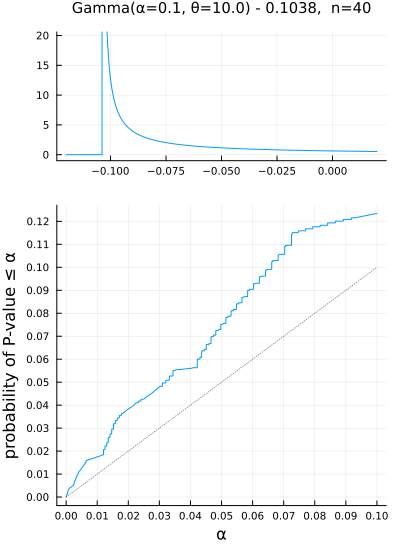

In [13]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20)

Xᵢ ~ Gamma(α=0.1, θ=10.0) - 0.1038
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.3349
median(X₁)) = -0.0979
mean(X₁)) = 0.8962


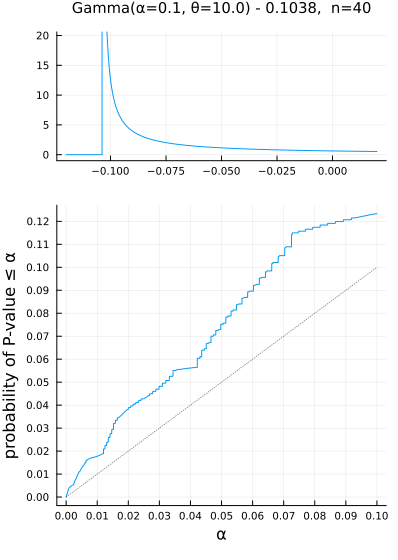

In [14]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20)

Xᵢ ~ Gamma(α=0.05, θ=20.0) - 0.005935
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.3157
median(X₁)) = -0.0059
mean(X₁)) = 0.9941


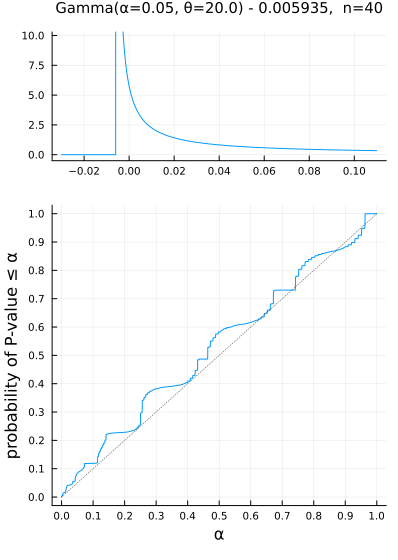

In [15]:
plot_sim_signed_rank_test(Gamma(0.05, 20), 40; xmin=-0.03, xmax=0.11, amax=1)

Xᵢ ~ Gamma(α=0.05, θ=20.0) - 0.005942
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.3156
median(X₁)) = -0.0059
mean(X₁)) = 0.9941


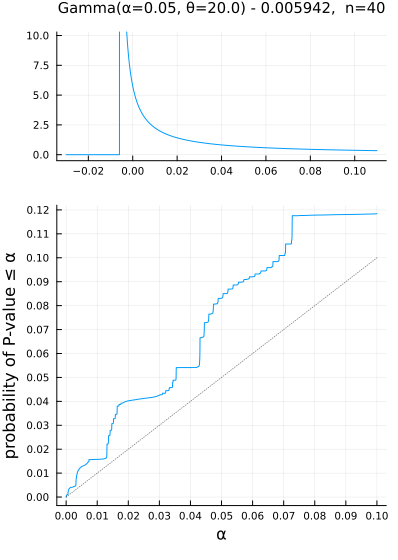

In [16]:
plot_sim_signed_rank_test(Gamma(0.05, 20), 40; xmin=-0.03, xmax=0.11)

Xᵢ ~ Gamma(α=0.05, θ=20.0) - 0.005933
P(X₁ + X₂ > 0) = 0.5001
P(X₁ > 0) = 0.3157
median(X₁)) = -0.0059
mean(X₁)) = 0.9941


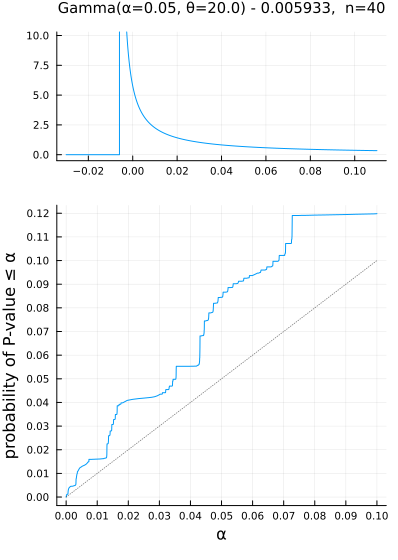

In [17]:
plot_sim_signed_rank_test(Gamma(0.05, 20), 40; xmin=-0.03, xmax=0.11)